###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [3]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [4]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
95,Australia,2021,7.112,10.815,0.920,71.050,0.912,0.234,0.454,0.740,0.235
106,Austria,2016,7.048,10.885,0.926,70.525,0.889,0.074,0.524,0.713,0.197
2008,Switzerland,2014,7.493,11.111,0.959,71.640,0.949,0.053,0.283,0.788,0.189
1037,Japan,2015,5.880,10.607,0.923,73.600,0.832,-0.162,0.654,0.702,0.176
54,Argentina,2014,6.671,10.067,0.918,66.780,0.745,-0.170,0.854,0.769,0.238


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [5]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [6]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [7]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [8]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [9]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\Sohin\AppData\Local\Temp\ipykernel_43268\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


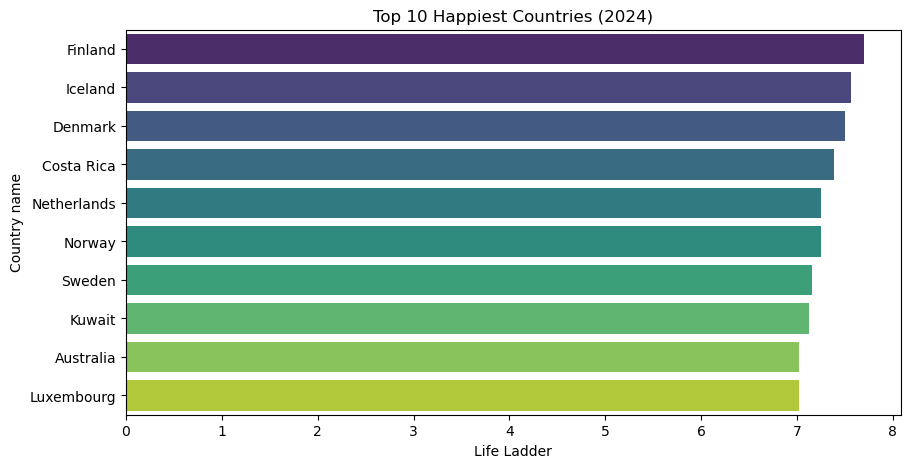

C:\Users\Sohin\AppData\Local\Temp\ipykernel_43268\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


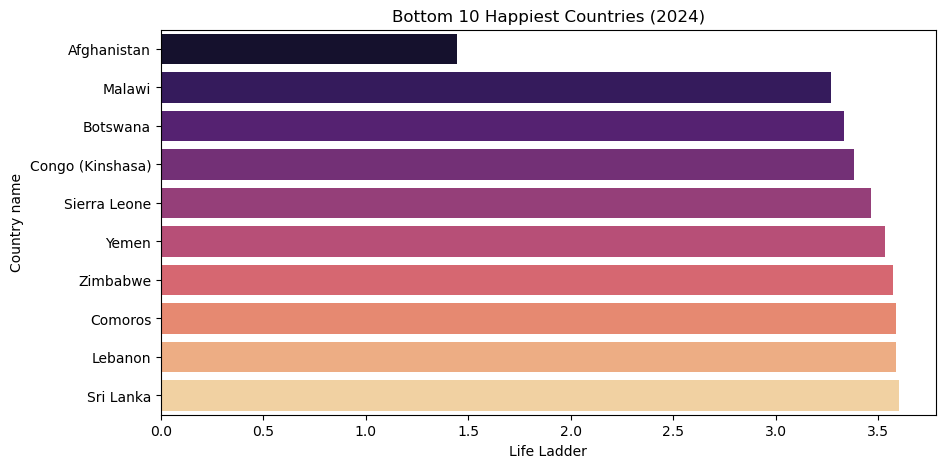

In [10]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


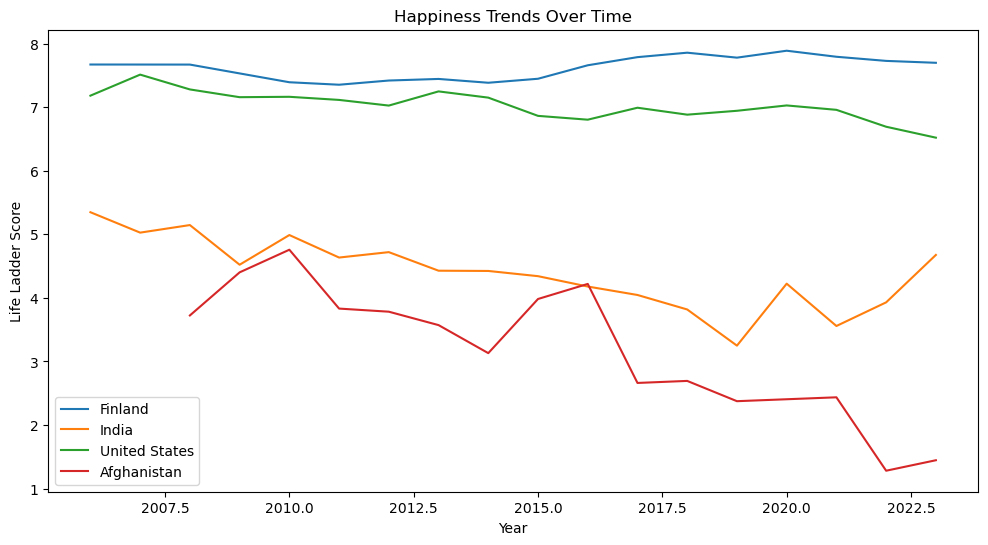

In [11]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


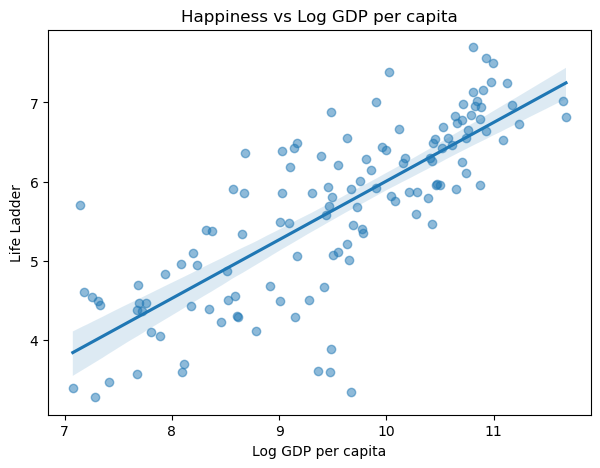

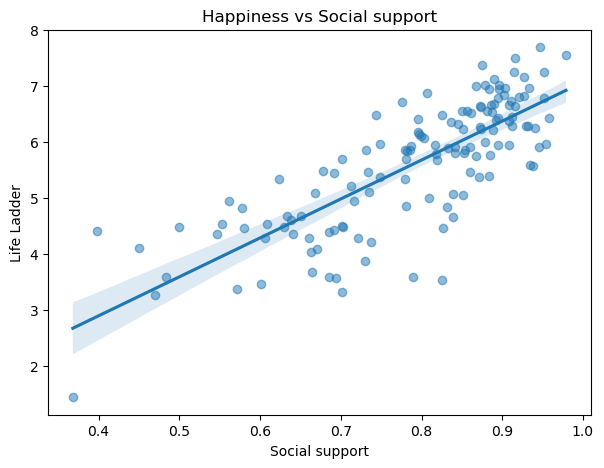

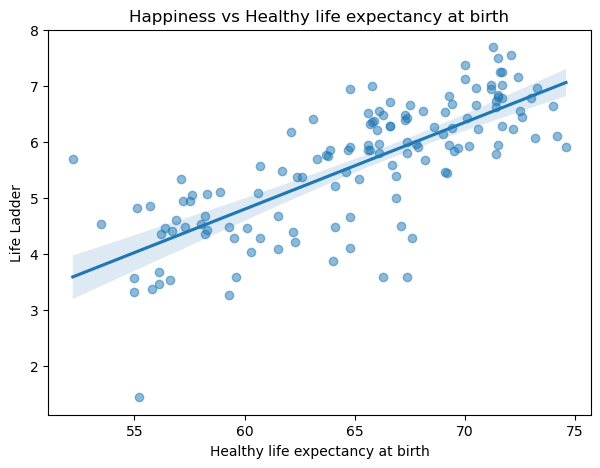

In [12]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


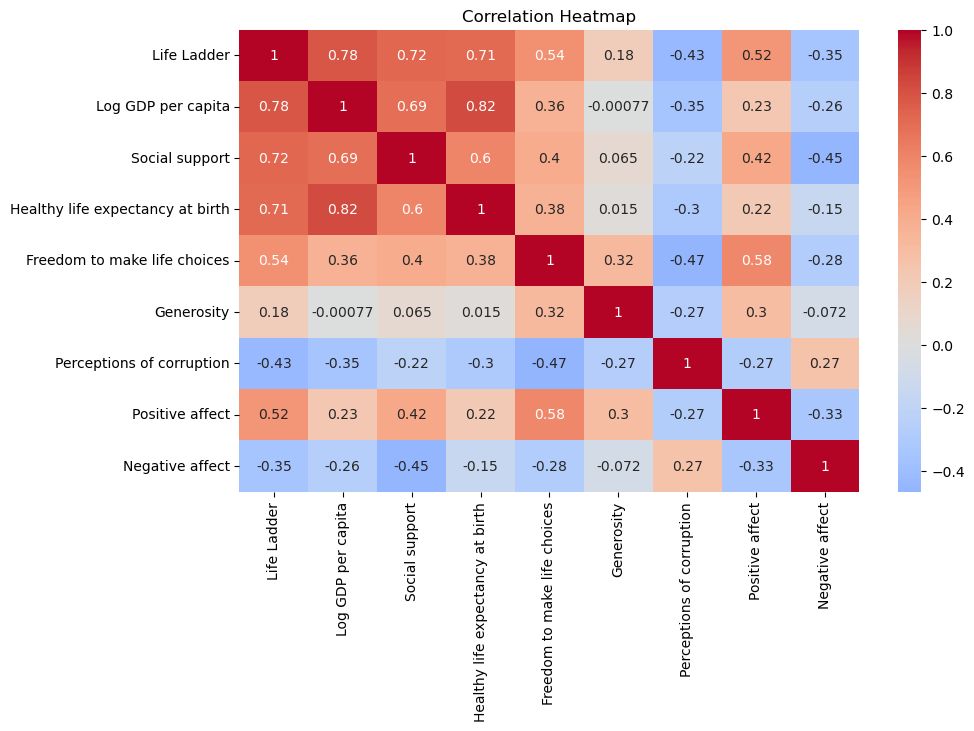

In [13]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


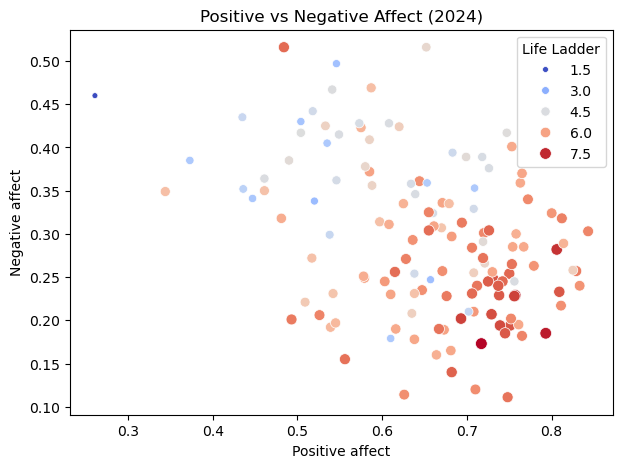

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [16]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [17]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [18]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [19]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [20]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [21]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [22]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [23]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [24]:
data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
data.sample(10)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,country_label
1020,Jamaica,2011,5.374,9.193,0.855,66.600,0.796,-0.071,0.909,0.764,0.237,69
1358,Mexico,2012,7.320,9.844,0.767,65.380,0.788,-0.099,0.633,0.722,0.278,91
1715,Portugal,2022,5.953,10.484,0.862,71.375,0.903,-0.139,0.893,0.638,0.316,113
1531,Nicaragua,2021,6.095,8.647,0.848,65.650,0.905,0.020,0.675,0.799,0.293,102
503,Croatia,2020,6.508,10.202,0.923,68.775,0.837,-0.071,0.961,0.681,0.286,34
168,Belarus,2014,5.812,9.858,0.880,64.540,0.647,-0.054,0.682,0.575,0.209,11
2235,United States,2016,6.804,10.985,0.897,66.475,0.758,0.138,0.739,0.737,0.264,147
2019,Syria,2009,4.979,8.656,0.842,66.860,0.748,0.076,0.688,0.491,0.292,134
1449,Myanmar,2018,4.411,8.424,0.774,60.575,0.906,0.492,0.647,0.640,0.300,97
786,Greece,2022,5.900,10.358,0.875,71.275,0.563,-0.318,0.874,0.589,0.183,53


Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [25]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1725 non-null   object 
 1   year                              1725 non-null   int64  
 2   Life Ladder                       1725 non-null   float64
 3   Log GDP per capita                1725 non-null   float64
 4   Social support                    1725 non-null   float64
 5   Healthy life expectancy at birth  1725 non-null   float64
 6   Freedom to make life choices      1725 non-null   float64
 7   Generosity                        1725 non-null   float64
 8   Perceptions of corruption         1725 non-null   float64
 9   Positive affect                   1725 non-null   float64
 10  Negative affect                   1725 non-null   float64
 11  country_label                     1725 non-null   int16  
dtypes: float64(

In [26]:
features_train = training.drop(['Life Ladder', 'Country name'], axis=1)
features_test = test.drop(['Life Ladder', 'Country name'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [27]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3925387796713835

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [28]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-29 09:02:30,893] A new study created in memory with name: no-name-fef85aa6-6512-49fd-b60b-19ce656910d6
[I 2025-09-29 09:02:31,228] Trial 0 finished with value: 0.32872788259718155 and parameters: {'n_estimators': 30, 'max_depth': 12}. Best is trial 0 with value: 0.32872788259718155.
[I 2025-09-29 09:02:31,409] Trial 1 finished with value: 0.3405774306531937 and parameters: {'n_estimators': 10, 'max_depth': 14}. Best is trial 0 with value: 0.32872788259718155.
[I 2025-09-29 09:02:32,277] Trial 2 finished with value: 0.3255599069633181 and parameters: {'n_estimators': 170, 'max_depth': 11}. Best is trial 2 with value: 0.3255599069633181.
[I 2025-09-29 09:02:32,314] Trial 3 finished with value: 0.3622753351870037 and parameters: {'n_estimators': 30, 'max_depth': 7}. Best is trial 2 with value: 0.3255599069633181.
[I 2025-09-29 09:02:33,452] Trial 4 finished with value: 0.3210629239839221 and parameters: {'n_estimators': 130, 'max_depth': 13}. Best is trial 4 with value: 0.32106

In [29]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 40, 'max_depth': 13}
At trial:  23
Mean absolute error:  0.3135251927035196

Hyperparameter importances:


{'max_depth': 0.7330942320735626, 'n_estimators': 0.26690576792643733}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [48]:
from sklearn.ensemble import RandomForestRegressor

rtf = RandomForestRegressor()
rtf.fit(features_train, target_train)
rtf_pred = rtf.predict(features_test)
rtf_mae = mean_absolute_error(target_test, rtf_pred)
rtf_mae


0.32486000000000004

In [51]:
from sklearn.tree import DecisionTreeRegressor

dtr= DecisionTreeRegressor()
dtr.fit(features_train, target_train)
dtr_pred = rtf.predict(features_test)
dtr_mae = mean_absolute_error(target_test, dtr_pred)
dtr_mae


0.32486000000000004

In [52]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor()
cbr.fit(features_train, target_train)
cbr_pred = cbr.predict(features_test)
cbr_mae = mean_absolute_error(target_test, cbr_pred)
cbr_mae

Learning rate set to 0.044626
0:	learn: 1.0963346	total: 140ms	remaining: 2m 20s
1:	learn: 1.0612144	total: 142ms	remaining: 1m 10s
2:	learn: 1.0278523	total: 143ms	remaining: 47.6s
3:	learn: 0.9969295	total: 145ms	remaining: 36s
4:	learn: 0.9668442	total: 146ms	remaining: 29.1s
5:	learn: 0.9395862	total: 147ms	remaining: 24.4s
6:	learn: 0.9135088	total: 149ms	remaining: 21.1s
7:	learn: 0.8885151	total: 150ms	remaining: 18.6s
8:	learn: 0.8644008	total: 151ms	remaining: 16.7s
9:	learn: 0.8415540	total: 153ms	remaining: 15.1s
10:	learn: 0.8191188	total: 154ms	remaining: 13.8s
11:	learn: 0.7982412	total: 155ms	remaining: 12.8s
12:	learn: 0.7780339	total: 156ms	remaining: 11.9s
13:	learn: 0.7612855	total: 158ms	remaining: 11.1s
14:	learn: 0.7434443	total: 159ms	remaining: 10.4s
15:	learn: 0.7261445	total: 160ms	remaining: 9.87s
16:	learn: 0.7112221	total: 162ms	remaining: 9.36s
17:	learn: 0.6965188	total: 163ms	remaining: 8.9s
18:	learn: 0.6837074	total: 165ms	remaining: 8.49s
19:	learn: 0

0.29024782039418323

In [47]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(features_train, target_train)
lgbm_pred = lgbm.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, lgbm_pred)
lgbm_mae

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 10
[LightGBM] [Info] Start training from score 5.448597


0.3077101680480545

In [54]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-29 09:35:34,318] A new study created in memory with name: no-name-1469be6c-b275-41d1-a1f3-207fe077665d
[I 2025-09-29 09:35:34,422] Trial 0 finished with value: 0.3798128663527889 and parameters: {'n_estimators': 130, 'max_depth': 1}. Best is trial 0 with value: 0.3798128663527889.


Learning rate set to 0.234399
0:	learn: 1.0209175	total: 510us	remaining: 65.9ms
1:	learn: 0.9363348	total: 875us	remaining: 56ms
2:	learn: 0.8548843	total: 1.24ms	remaining: 52.7ms
3:	learn: 0.8041198	total: 1.54ms	remaining: 48.6ms
4:	learn: 0.7579558	total: 1.89ms	remaining: 47.2ms
5:	learn: 0.7115287	total: 2.18ms	remaining: 45.1ms
6:	learn: 0.6834668	total: 2.48ms	remaining: 43.6ms
7:	learn: 0.6533631	total: 2.77ms	remaining: 42.2ms
8:	learn: 0.6294393	total: 3.07ms	remaining: 41.3ms
9:	learn: 0.6089414	total: 3.48ms	remaining: 41.7ms
10:	learn: 0.5924942	total: 3.77ms	remaining: 40.8ms
11:	learn: 0.5778872	total: 4.14ms	remaining: 40.7ms
12:	learn: 0.5662862	total: 4.47ms	remaining: 40.2ms
13:	learn: 0.5585756	total: 4.76ms	remaining: 39.5ms
14:	learn: 0.5515706	total: 5.09ms	remaining: 39ms
15:	learn: 0.5451126	total: 5.39ms	remaining: 38.4ms
16:	learn: 0.5380723	total: 5.73ms	remaining: 38.1ms
17:	learn: 0.5332047	total: 6.02ms	remaining: 37.5ms
18:	learn: 0.5291616	total: 6.52

[I 2025-09-29 09:35:35,889] Trial 1 finished with value: 0.3449315585020393 and parameters: {'n_estimators': 70, 'max_depth': 11}. Best is trial 1 with value: 0.3449315585020393.


68:	learn: 0.0712429	total: 1.38s	remaining: 20ms
69:	learn: 0.0694594	total: 1.4s	remaining: 0us
Learning rate set to 0.172173
0:	learn: 1.0037408	total: 13.7ms	remaining: 2.6s
1:	learn: 0.8952693	total: 28.3ms	remaining: 2.66s
2:	learn: 0.8013343	total: 39.9ms	remaining: 2.49s
3:	learn: 0.7354263	total: 51.8ms	remaining: 2.41s
4:	learn: 0.6692527	total: 62.1ms	remaining: 2.3s
5:	learn: 0.6145664	total: 72.5ms	remaining: 2.22s
6:	learn: 0.5696005	total: 82.8ms	remaining: 2.16s
7:	learn: 0.5337616	total: 93.2ms	remaining: 2.12s
8:	learn: 0.4991361	total: 103ms	remaining: 2.08s
9:	learn: 0.4723740	total: 114ms	remaining: 2.04s
10:	learn: 0.4502653	total: 124ms	remaining: 2.02s
11:	learn: 0.4333016	total: 134ms	remaining: 1.99s
12:	learn: 0.4150182	total: 145ms	remaining: 1.98s
13:	learn: 0.4024875	total: 158ms	remaining: 1.98s
14:	learn: 0.3883635	total: 169ms	remaining: 1.98s
15:	learn: 0.3778246	total: 180ms	remaining: 1.96s
16:	learn: 0.3654618	total: 191ms	remaining: 1.94s
17:	learn

[I 2025-09-29 09:35:38,011] Trial 2 finished with value: 0.31181322134453854 and parameters: {'n_estimators': 190, 'max_depth': 10}. Best is trial 2 with value: 0.31181322134453854.
[I 2025-09-29 09:35:38,145] Trial 3 finished with value: 0.33084964698509006 and parameters: {'n_estimators': 140, 'max_depth': 3}. Best is trial 2 with value: 0.31181322134453854.


188:	learn: 0.0682317	total: 2.01s	remaining: 10.6ms
189:	learn: 0.0675231	total: 2.02s	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9661667	total: 814us	remaining: 113ms
1:	learn: 0.8468309	total: 1.36ms	remaining: 93.6ms
2:	learn: 0.7478388	total: 1.88ms	remaining: 85.7ms
3:	learn: 0.6853158	total: 2.39ms	remaining: 81.4ms
4:	learn: 0.6293621	total: 2.97ms	remaining: 80.2ms
5:	learn: 0.5895520	total: 3.44ms	remaining: 76.8ms
6:	learn: 0.5636342	total: 3.93ms	remaining: 74.7ms
7:	learn: 0.5459417	total: 4.43ms	remaining: 73.1ms
8:	learn: 0.5312703	total: 4.92ms	remaining: 71.7ms
9:	learn: 0.5171886	total: 5.39ms	remaining: 70.1ms
10:	learn: 0.5088593	total: 5.91ms	remaining: 69.3ms
11:	learn: 0.5026979	total: 6.38ms	remaining: 68ms
12:	learn: 0.4968809	total: 6.93ms	remaining: 67.7ms
13:	learn: 0.4917766	total: 7.46ms	remaining: 67.1ms
14:	learn: 0.4870294	total: 8.22ms	remaining: 68.5ms
15:	learn: 0.4839393	total: 8.99ms	remaining: 69.7ms
16:	learn: 0.4804145	total: 9.57m

[I 2025-09-29 09:35:49,713] Trial 4 finished with value: 0.3993525507668567 and parameters: {'n_estimators': 40, 'max_depth': 15}. Best is trial 2 with value: 0.31181322134453854.


39:	learn: 0.0415046	total: 11.4s	remaining: 0us
Learning rate set to 0.34784
0:	learn: 0.8662685	total: 2.39ms	remaining: 189ms
1:	learn: 0.7053022	total: 4.74ms	remaining: 185ms
2:	learn: 0.5937481	total: 6.85ms	remaining: 176ms
3:	learn: 0.5278606	total: 9.24ms	remaining: 176ms
4:	learn: 0.4853334	total: 11.8ms	remaining: 177ms
5:	learn: 0.4624691	total: 13.5ms	remaining: 167ms
6:	learn: 0.4461324	total: 15.5ms	remaining: 162ms
7:	learn: 0.4315910	total: 17.7ms	remaining: 159ms
8:	learn: 0.4220153	total: 20.7ms	remaining: 163ms
9:	learn: 0.4122758	total: 23.1ms	remaining: 162ms
10:	learn: 0.4061777	total: 25.2ms	remaining: 158ms
11:	learn: 0.4010098	total: 27.6ms	remaining: 156ms
12:	learn: 0.3906308	total: 29.4ms	remaining: 152ms
13:	learn: 0.3842635	total: 31.3ms	remaining: 148ms
14:	learn: 0.3752186	total: 32.9ms	remaining: 143ms
15:	learn: 0.3699640	total: 34.6ms	remaining: 138ms
16:	learn: 0.3634772	total: 36.8ms	remaining: 136ms
17:	learn: 0.3587547	total: 38.8ms	remaining: 13

[I 2025-09-29 09:35:49,915] Trial 5 finished with value: 0.3228794385014706 and parameters: {'n_estimators': 80, 'max_depth': 7}. Best is trial 2 with value: 0.31181322134453854.


38:	learn: 0.2649318	total: 76.3ms	remaining: 80.2ms
39:	learn: 0.2605952	total: 78ms	remaining: 78ms
40:	learn: 0.2581966	total: 79.6ms	remaining: 75.7ms
41:	learn: 0.2556938	total: 81.5ms	remaining: 73.7ms
42:	learn: 0.2533333	total: 83.4ms	remaining: 71.7ms
43:	learn: 0.2508565	total: 85ms	remaining: 69.6ms
44:	learn: 0.2502328	total: 86.7ms	remaining: 67.4ms
45:	learn: 0.2480735	total: 88.6ms	remaining: 65.5ms
46:	learn: 0.2445898	total: 90.4ms	remaining: 63.5ms
47:	learn: 0.2412287	total: 92.2ms	remaining: 61.5ms
48:	learn: 0.2384638	total: 94.1ms	remaining: 59.6ms
49:	learn: 0.2361547	total: 96.5ms	remaining: 57.9ms
50:	learn: 0.2320235	total: 98.6ms	remaining: 56.1ms
51:	learn: 0.2303811	total: 100ms	remaining: 54ms
52:	learn: 0.2278382	total: 102ms	remaining: 52.1ms
53:	learn: 0.2248379	total: 104ms	remaining: 50.1ms
54:	learn: 0.2230825	total: 106ms	remaining: 48.1ms
55:	learn: 0.2207060	total: 107ms	remaining: 46.1ms
56:	learn: 0.2181470	total: 109ms	remaining: 44.1ms
57:	lea

[I 2025-09-29 09:35:50,076] Trial 6 finished with value: 0.33274204957252823 and parameters: {'n_estimators': 90, 'max_depth': 6}. Best is trial 2 with value: 0.31181322134453854.
[I 2025-09-29 09:35:50,154] Trial 7 pruned. 


63:	learn: 0.2440301	total: 77ms	remaining: 31.3ms
64:	learn: 0.2416264	total: 78.4ms	remaining: 30.2ms
65:	learn: 0.2404211	total: 79.8ms	remaining: 29ms
66:	learn: 0.2389278	total: 81.2ms	remaining: 27.9ms
67:	learn: 0.2372594	total: 82.4ms	remaining: 26.6ms
68:	learn: 0.2343991	total: 83.5ms	remaining: 25.4ms
69:	learn: 0.2323208	total: 84.6ms	remaining: 24.2ms
70:	learn: 0.2306182	total: 85.6ms	remaining: 22.9ms
71:	learn: 0.2284348	total: 86.7ms	remaining: 21.7ms
72:	learn: 0.2275159	total: 87.7ms	remaining: 20.4ms
73:	learn: 0.2262220	total: 88.9ms	remaining: 19.2ms
74:	learn: 0.2250291	total: 90ms	remaining: 18ms
75:	learn: 0.2234697	total: 91.3ms	remaining: 16.8ms
76:	learn: 0.2211826	total: 92.7ms	remaining: 15.6ms
77:	learn: 0.2197501	total: 94.3ms	remaining: 14.5ms
78:	learn: 0.2187078	total: 95.7ms	remaining: 13.3ms
79:	learn: 0.2164233	total: 97.3ms	remaining: 12.2ms
80:	learn: 0.2136228	total: 98.7ms	remaining: 11ms
81:	learn: 0.2122971	total: 100ms	remaining: 9.75ms
82:	

[I 2025-09-29 09:35:50,285] Trial 8 pruned. 


99:	learn: 0.4229097	total: 41.3ms	remaining: 24.8ms
100:	learn: 0.4223218	total: 41.8ms	remaining: 24.4ms
101:	learn: 0.4212529	total: 42.2ms	remaining: 24ms
102:	learn: 0.4207441	total: 42.6ms	remaining: 23.6ms
103:	learn: 0.4194333	total: 43.1ms	remaining: 23.2ms
104:	learn: 0.4186902	total: 43.6ms	remaining: 22.8ms
105:	learn: 0.4175726	total: 44ms	remaining: 22.4ms
106:	learn: 0.4171050	total: 44.5ms	remaining: 22ms
107:	learn: 0.4164212	total: 44.9ms	remaining: 21.6ms
108:	learn: 0.4159725	total: 45.3ms	remaining: 21.2ms
109:	learn: 0.4151017	total: 45.7ms	remaining: 20.8ms
110:	learn: 0.4145487	total: 46.1ms	remaining: 20.3ms
111:	learn: 0.4143651	total: 46.4ms	remaining: 19.9ms
112:	learn: 0.4140918	total: 46.8ms	remaining: 19.5ms
113:	learn: 0.4132580	total: 47.2ms	remaining: 19.1ms
114:	learn: 0.4131130	total: 47.6ms	remaining: 18.6ms
115:	learn: 0.4126516	total: 48.1ms	remaining: 18.2ms
116:	learn: 0.4122172	total: 48.4ms	remaining: 17.8ms
117:	learn: 0.4116657	total: 48.8ms

[I 2025-09-29 09:36:06,593] Trial 9 pruned. 


59:	learn: 0.0233232	total: 16.1s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0107297	total: 20.9ms	remaining: 4.17s
1:	learn: 0.9036396	total: 40.4ms	remaining: 4s
2:	learn: 0.8140214	total: 61.1ms	remaining: 4.01s
3:	learn: 0.7412094	total: 81.1ms	remaining: 3.97s
4:	learn: 0.6828988	total: 101ms	remaining: 3.94s
5:	learn: 0.6299432	total: 121ms	remaining: 3.92s
6:	learn: 0.5811796	total: 141ms	remaining: 3.88s
7:	learn: 0.5415698	total: 161ms	remaining: 3.86s
8:	learn: 0.5077045	total: 181ms	remaining: 3.85s
9:	learn: 0.4804741	total: 201ms	remaining: 3.82s
10:	learn: 0.4559255	total: 222ms	remaining: 3.81s
11:	learn: 0.4333755	total: 241ms	remaining: 3.78s
12:	learn: 0.4141624	total: 262ms	remaining: 3.77s
13:	learn: 0.3987576	total: 282ms	remaining: 3.74s
14:	learn: 0.3841140	total: 301ms	remaining: 3.72s
15:	learn: 0.3719637	total: 322ms	remaining: 3.71s
16:	learn: 0.3604488	total: 343ms	remaining: 3.69s
17:	learn: 0.3488589	total: 363ms	remaining: 3.67s
18:	learn: 0

[I 2025-09-29 09:36:10,668] Trial 10 finished with value: 0.31947560438478356 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 2 with value: 0.31181322134453854.


196:	learn: 0.0518606	total: 3.9s	remaining: 59.4ms
197:	learn: 0.0514417	total: 3.92s	remaining: 39.6ms
198:	learn: 0.0508506	total: 3.94s	remaining: 19.8ms
199:	learn: 0.0506490	total: 3.96s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0088390	total: 10.9ms	remaining: 2.17s
1:	learn: 0.9038565	total: 22.2ms	remaining: 2.2s
2:	learn: 0.8122275	total: 33.4ms	remaining: 2.19s
3:	learn: 0.7473206	total: 44.5ms	remaining: 2.18s
4:	learn: 0.6797549	total: 54.9ms	remaining: 2.14s
5:	learn: 0.6262531	total: 65.9ms	remaining: 2.13s
6:	learn: 0.5820542	total: 77ms	remaining: 2.12s
7:	learn: 0.5448359	total: 87.7ms	remaining: 2.1s
8:	learn: 0.5118105	total: 98.2ms	remaining: 2.08s
9:	learn: 0.4840500	total: 109ms	remaining: 2.07s
10:	learn: 0.4623380	total: 120ms	remaining: 2.06s
11:	learn: 0.4421412	total: 131ms	remaining: 2.05s
12:	learn: 0.4238376	total: 141ms	remaining: 2.03s
13:	learn: 0.4117224	total: 152ms	remaining: 2.02s
14:	learn: 0.3989750	total: 162ms	remaining: 2s
15:	l

[I 2025-09-29 09:36:12,951] Trial 11 finished with value: 0.31283660489045245 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 2 with value: 0.31181322134453854.


198:	learn: 0.0648295	total: 2.17s	remaining: 10.9ms
199:	learn: 0.0644020	total: 2.18s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0088390	total: 10.9ms	remaining: 2.17s
1:	learn: 0.9038565	total: 22.1ms	remaining: 2.19s
2:	learn: 0.8122275	total: 32.7ms	remaining: 2.15s
3:	learn: 0.7473206	total: 43.5ms	remaining: 2.13s
4:	learn: 0.6797549	total: 54.3ms	remaining: 2.12s
5:	learn: 0.6262531	total: 65.2ms	remaining: 2.11s
6:	learn: 0.5820542	total: 76.9ms	remaining: 2.12s
7:	learn: 0.5448359	total: 88.1ms	remaining: 2.12s
8:	learn: 0.5118105	total: 99.2ms	remaining: 2.11s
9:	learn: 0.4840500	total: 111ms	remaining: 2.1s
10:	learn: 0.4623380	total: 122ms	remaining: 2.09s
11:	learn: 0.4421412	total: 132ms	remaining: 2.06s
12:	learn: 0.4238376	total: 143ms	remaining: 2.06s
13:	learn: 0.4117224	total: 156ms	remaining: 2.07s
14:	learn: 0.3989750	total: 167ms	remaining: 2.05s
15:	learn: 0.3909690	total: 177ms	remaining: 2.04s
16:	learn: 0.3789580	total: 189ms	remaining: 2.03s
17

[I 2025-09-29 09:36:15,243] Trial 12 finished with value: 0.31283660489045245 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 2 with value: 0.31181322134453854.


188:	learn: 0.0700580	total: 2.07s	remaining: 120ms
189:	learn: 0.0697431	total: 2.08s	remaining: 109ms
190:	learn: 0.0689545	total: 2.09s	remaining: 98.5ms
191:	learn: 0.0683139	total: 2.1s	remaining: 87.5ms
192:	learn: 0.0677898	total: 2.11s	remaining: 76.6ms
193:	learn: 0.0673520	total: 2.12s	remaining: 65.6ms
194:	learn: 0.0670043	total: 2.13s	remaining: 54.7ms
195:	learn: 0.0665146	total: 2.14s	remaining: 43.7ms
196:	learn: 0.0657833	total: 2.15s	remaining: 32.8ms
197:	learn: 0.0654677	total: 2.17s	remaining: 21.9ms
198:	learn: 0.0648295	total: 2.17s	remaining: 10.9ms
199:	learn: 0.0644020	total: 2.19s	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9861657	total: 5.29ms	remaining: 894ms
1:	learn: 0.8699553	total: 9.76ms	remaining: 819ms
2:	learn: 0.7712661	total: 15.5ms	remaining: 862ms
3:	learn: 0.6967856	total: 20.3ms	remaining: 843ms
4:	learn: 0.6335173	total: 24.9ms	remaining: 821ms
5:	learn: 0.5843105	total: 30.6ms	remaining: 836ms
6:	learn: 0.5421939	total: 35.8ms	

[I 2025-09-29 09:36:16,225] Trial 13 finished with value: 0.3093389291950824 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 13 with value: 0.3093389291950824.


154:	learn: 0.1011938	total: 821ms	remaining: 79.4ms
155:	learn: 0.1007752	total: 826ms	remaining: 74.2ms
156:	learn: 0.1003475	total: 831ms	remaining: 68.8ms
157:	learn: 0.0994466	total: 837ms	remaining: 63.6ms
158:	learn: 0.0983589	total: 842ms	remaining: 58.3ms
159:	learn: 0.0974292	total: 847ms	remaining: 52.9ms
160:	learn: 0.0969541	total: 852ms	remaining: 47.6ms
161:	learn: 0.0964115	total: 858ms	remaining: 42.4ms
162:	learn: 0.0956792	total: 863ms	remaining: 37.1ms
163:	learn: 0.0948272	total: 869ms	remaining: 31.8ms
164:	learn: 0.0943702	total: 874ms	remaining: 26.5ms
165:	learn: 0.0939631	total: 880ms	remaining: 21.2ms
166:	learn: 0.0934983	total: 885ms	remaining: 15.9ms
167:	learn: 0.0932043	total: 890ms	remaining: 10.6ms
168:	learn: 0.0926434	total: 896ms	remaining: 5.3ms
169:	learn: 0.0920503	total: 901ms	remaining: 0us
Learning rate set to 0.188468
0:	learn: 1.0008822	total: 74.5ms	remaining: 12.6s
1:	learn: 0.8921540	total: 149ms	remaining: 12.5s
2:	learn: 0.8014878	total

[I 2025-09-29 09:36:28,871] Trial 14 pruned. 


169:	learn: 0.0264585	total: 12.4s	remaining: 0us
Learning rate set to 0.25016
0:	learn: 0.9399631	total: 3.31ms	remaining: 394ms
1:	learn: 0.8072902	total: 5.92ms	remaining: 349ms
2:	learn: 0.6978312	total: 8.49ms	remaining: 331ms
3:	learn: 0.6172452	total: 11ms	remaining: 320ms
4:	learn: 0.5600463	total: 13.6ms	remaining: 314ms
5:	learn: 0.5172161	total: 16.6ms	remaining: 315ms
6:	learn: 0.4854323	total: 19.3ms	remaining: 311ms
7:	learn: 0.4607216	total: 22.2ms	remaining: 311ms
8:	learn: 0.4417485	total: 25.1ms	remaining: 310ms
9:	learn: 0.4239754	total: 28.2ms	remaining: 310ms
10:	learn: 0.4101809	total: 31.5ms	remaining: 312ms
11:	learn: 0.3997792	total: 34.4ms	remaining: 310ms
12:	learn: 0.3922180	total: 37.5ms	remaining: 309ms
13:	learn: 0.3837289	total: 40.4ms	remaining: 306ms
14:	learn: 0.3731992	total: 43.6ms	remaining: 306ms
15:	learn: 0.3665592	total: 46.6ms	remaining: 303ms
16:	learn: 0.3613082	total: 50.4ms	remaining: 305ms
17:	learn: 0.3588315	total: 53.5ms	remaining: 303

[I 2025-09-29 09:36:29,289] Trial 15 pruned. 


86:	learn: 0.1692778	total: 254ms	remaining: 96.4ms
87:	learn: 0.1678899	total: 257ms	remaining: 93.5ms
88:	learn: 0.1662182	total: 261ms	remaining: 90.9ms
89:	learn: 0.1652699	total: 264ms	remaining: 88.1ms
90:	learn: 0.1638543	total: 267ms	remaining: 85.2ms
91:	learn: 0.1618840	total: 270ms	remaining: 82.2ms
92:	learn: 0.1600572	total: 273ms	remaining: 79.2ms
93:	learn: 0.1580710	total: 276ms	remaining: 76.2ms
94:	learn: 0.1560717	total: 279ms	remaining: 73.3ms
95:	learn: 0.1549922	total: 281ms	remaining: 70.3ms
96:	learn: 0.1541658	total: 284ms	remaining: 67.4ms
97:	learn: 0.1534606	total: 287ms	remaining: 64.5ms
98:	learn: 0.1523570	total: 290ms	remaining: 61.6ms
99:	learn: 0.1500506	total: 293ms	remaining: 58.7ms
100:	learn: 0.1484789	total: 296ms	remaining: 55.7ms
101:	learn: 0.1469683	total: 299ms	remaining: 52.8ms
102:	learn: 0.1460771	total: 302ms	remaining: 49.8ms
103:	learn: 0.1455817	total: 305ms	remaining: 46.9ms
104:	learn: 0.1448360	total: 308ms	remaining: 44ms
105:	lear

[I 2025-09-29 09:36:29,495] Trial 16 finished with value: 0.3148426374980417 and parameters: {'n_estimators': 160, 'max_depth': 5}. Best is trial 13 with value: 0.3093389291950824.


33:	learn: 0.4078428	total: 44.7ms	remaining: 166ms
34:	learn: 0.4028010	total: 45.9ms	remaining: 164ms
35:	learn: 0.4016719	total: 47ms	remaining: 162ms
36:	learn: 0.3984718	total: 47.8ms	remaining: 159ms
37:	learn: 0.3970790	total: 48.6ms	remaining: 156ms
38:	learn: 0.3948090	total: 49.4ms	remaining: 153ms
39:	learn: 0.3923697	total: 50.2ms	remaining: 151ms
40:	learn: 0.3896225	total: 51ms	remaining: 148ms
41:	learn: 0.3867112	total: 51.7ms	remaining: 145ms
42:	learn: 0.3842377	total: 52.5ms	remaining: 143ms
43:	learn: 0.3832277	total: 53.3ms	remaining: 141ms
44:	learn: 0.3807645	total: 54.1ms	remaining: 138ms
45:	learn: 0.3791914	total: 54.9ms	remaining: 136ms
46:	learn: 0.3768830	total: 55.7ms	remaining: 134ms
47:	learn: 0.3732354	total: 56.6ms	remaining: 132ms
48:	learn: 0.3718704	total: 57.4ms	remaining: 130ms
49:	learn: 0.3685291	total: 58.2ms	remaining: 128ms
50:	learn: 0.3672238	total: 59.2ms	remaining: 126ms
51:	learn: 0.3660257	total: 60.3ms	remaining: 125ms
52:	learn: 0.364

[I 2025-09-29 09:36:30,571] Trial 17 finished with value: 0.3093743589307658 and parameters: {'n_estimators': 180, 'max_depth': 9}. Best is trial 13 with value: 0.3093389291950824.


153:	learn: 0.1053970	total: 858ms	remaining: 145ms
154:	learn: 0.1050420	total: 863ms	remaining: 139ms
155:	learn: 0.1040308	total: 869ms	remaining: 134ms
156:	learn: 0.1038520	total: 874ms	remaining: 128ms
157:	learn: 0.1036277	total: 880ms	remaining: 122ms
158:	learn: 0.1030778	total: 885ms	remaining: 117ms
159:	learn: 0.1026851	total: 891ms	remaining: 111ms
160:	learn: 0.1021942	total: 897ms	remaining: 106ms
161:	learn: 0.1015868	total: 902ms	remaining: 100ms
162:	learn: 0.1007995	total: 907ms	remaining: 94.6ms
163:	learn: 0.1004417	total: 909ms	remaining: 88.7ms
164:	learn: 0.0995392	total: 915ms	remaining: 83.1ms
165:	learn: 0.0985923	total: 919ms	remaining: 77.5ms
166:	learn: 0.0980940	total: 924ms	remaining: 71.9ms
167:	learn: 0.0978407	total: 929ms	remaining: 66.4ms
168:	learn: 0.0971249	total: 935ms	remaining: 60.8ms
169:	learn: 0.0964897	total: 940ms	remaining: 55.3ms
170:	learn: 0.0963814	total: 945ms	remaining: 49.7ms
171:	learn: 0.0956174	total: 949ms	remaining: 44.2ms
17

[I 2025-09-29 09:36:30,684] Trial 18 pruned. 


6:	learn: 0.3995549	total: 20.8ms	remaining: 38.6ms
7:	learn: 0.3812686	total: 23.9ms	remaining: 35.8ms
8:	learn: 0.3670546	total: 26.7ms	remaining: 32.6ms
9:	learn: 0.3580410	total: 29.8ms	remaining: 29.8ms
10:	learn: 0.3502850	total: 32.5ms	remaining: 26.6ms
11:	learn: 0.3445386	total: 35.5ms	remaining: 23.7ms
12:	learn: 0.3351033	total: 39ms	remaining: 21ms
13:	learn: 0.3291681	total: 42ms	remaining: 18ms
14:	learn: 0.3192643	total: 45.2ms	remaining: 15.1ms
15:	learn: 0.3132262	total: 48.8ms	remaining: 12.2ms
16:	learn: 0.3075460	total: 52.2ms	remaining: 9.22ms
17:	learn: 0.3026538	total: 55.3ms	remaining: 6.14ms
18:	learn: 0.2928338	total: 58.6ms	remaining: 3.09ms
19:	learn: 0.2839212	total: 61.8ms	remaining: 0us
Learning rate set to 0.29013
0:	learn: 0.9330067	total: 76.7ms	remaining: 7.6s
1:	learn: 0.7843022	total: 151ms	remaining: 7.42s
2:	learn: 0.6691696	total: 226ms	remaining: 7.32s
3:	learn: 0.5861383	total: 301ms	remaining: 7.23s
4:	learn: 0.5150810	total: 375ms	remaining: 

[I 2025-09-29 09:36:38,229] Trial 19 pruned. 
[I 2025-09-29 09:36:38,443] Trial 20 finished with value: 0.312640628996053 and parameters: {'n_estimators': 180, 'max_depth': 5}. Best is trial 13 with value: 0.3093389291950824.


Learning rate set to 0.17991
0:	learn: 0.9893740	total: 1.75ms	remaining: 313ms
1:	learn: 0.8749598	total: 2.69ms	remaining: 239ms
2:	learn: 0.7878416	total: 3.59ms	remaining: 212ms
3:	learn: 0.7166820	total: 4.41ms	remaining: 194ms
4:	learn: 0.6603361	total: 5.27ms	remaining: 185ms
5:	learn: 0.6209070	total: 6.14ms	remaining: 178ms
6:	learn: 0.5848208	total: 7.2ms	remaining: 178ms
7:	learn: 0.5545126	total: 8.03ms	remaining: 173ms
8:	learn: 0.5319705	total: 8.77ms	remaining: 167ms
9:	learn: 0.5166996	total: 9.6ms	remaining: 163ms
10:	learn: 0.5038214	total: 10.4ms	remaining: 159ms
11:	learn: 0.4944878	total: 11.1ms	remaining: 156ms
12:	learn: 0.4869028	total: 11.9ms	remaining: 153ms
13:	learn: 0.4776226	total: 12.9ms	remaining: 153ms
14:	learn: 0.4718202	total: 14ms	remaining: 155ms
15:	learn: 0.4651150	total: 14.9ms	remaining: 153ms
16:	learn: 0.4604301	total: 15.8ms	remaining: 151ms
17:	learn: 0.4565444	total: 16.5ms	remaining: 149ms
18:	learn: 0.4529951	total: 17.3ms	remaining: 146

[I 2025-09-29 09:36:39,499] Trial 21 finished with value: 0.3093743589307658 and parameters: {'n_estimators': 180, 'max_depth': 9}. Best is trial 13 with value: 0.3093389291950824.


150:	learn: 0.1072477	total: 818ms	remaining: 157ms
151:	learn: 0.1065527	total: 823ms	remaining: 152ms
152:	learn: 0.1056896	total: 828ms	remaining: 146ms
153:	learn: 0.1053970	total: 833ms	remaining: 141ms
154:	learn: 0.1050420	total: 839ms	remaining: 135ms
155:	learn: 0.1040308	total: 844ms	remaining: 130ms
156:	learn: 0.1038520	total: 849ms	remaining: 124ms
157:	learn: 0.1036277	total: 854ms	remaining: 119ms
158:	learn: 0.1030778	total: 860ms	remaining: 114ms
159:	learn: 0.1026851	total: 865ms	remaining: 108ms
160:	learn: 0.1021942	total: 871ms	remaining: 103ms
161:	learn: 0.1015868	total: 876ms	remaining: 97.3ms
162:	learn: 0.1007995	total: 882ms	remaining: 92ms
163:	learn: 0.1004417	total: 884ms	remaining: 86.2ms
164:	learn: 0.0995392	total: 889ms	remaining: 80.8ms
165:	learn: 0.0985923	total: 894ms	remaining: 75.4ms
166:	learn: 0.0980940	total: 901ms	remaining: 70.1ms
167:	learn: 0.0978407	total: 906ms	remaining: 64.7ms
168:	learn: 0.0971249	total: 911ms	remaining: 59.3ms
169:	l

[I 2025-09-29 09:36:40,405] Trial 22 pruned. 


147:	learn: 0.0945376	total: 811ms	remaining: 11ms
148:	learn: 0.0936659	total: 817ms	remaining: 5.48ms
149:	learn: 0.0931835	total: 823ms	remaining: 0us
Learning rate set to 0.17991
0:	learn: 0.9998753	total: 39.7ms	remaining: 7.1s
1:	learn: 0.8871321	total: 79.1ms	remaining: 7.04s
2:	learn: 0.7951089	total: 118ms	remaining: 6.94s
3:	learn: 0.7163524	total: 157ms	remaining: 6.9s
4:	learn: 0.6492807	total: 198ms	remaining: 6.92s
5:	learn: 0.5898824	total: 237ms	remaining: 6.88s
6:	learn: 0.5417069	total: 276ms	remaining: 6.83s
7:	learn: 0.5026882	total: 316ms	remaining: 6.79s
8:	learn: 0.4694990	total: 355ms	remaining: 6.75s
9:	learn: 0.4404530	total: 394ms	remaining: 6.7s
10:	learn: 0.4153098	total: 433ms	remaining: 6.65s
11:	learn: 0.3956332	total: 472ms	remaining: 6.61s
12:	learn: 0.3805879	total: 515ms	remaining: 6.61s
13:	learn: 0.3635910	total: 555ms	remaining: 6.58s
14:	learn: 0.3478159	total: 594ms	remaining: 6.53s
15:	learn: 0.3336600	total: 633ms	remaining: 6.49s
16:	learn: 0

[I 2025-09-29 09:36:47,654] Trial 23 pruned. 


177:	learn: 0.0379640	total: 7.02s	remaining: 78.9ms
178:	learn: 0.0377120	total: 7.06s	remaining: 39.5ms
179:	learn: 0.0374864	total: 7.1s	remaining: 0us
Learning rate set to 0.25016
0:	learn: 0.9373113	total: 2.43ms	remaining: 289ms
1:	learn: 0.7986098	total: 4.82ms	remaining: 285ms
2:	learn: 0.6934494	total: 6.52ms	remaining: 254ms
3:	learn: 0.6195851	total: 8.12ms	remaining: 236ms
4:	learn: 0.5614148	total: 9.65ms	remaining: 222ms
5:	learn: 0.5198261	total: 11.3ms	remaining: 215ms
6:	learn: 0.4956442	total: 13ms	remaining: 209ms
7:	learn: 0.4771055	total: 14.8ms	remaining: 207ms
8:	learn: 0.4647493	total: 16.8ms	remaining: 207ms
9:	learn: 0.4505328	total: 18.4ms	remaining: 203ms
10:	learn: 0.4392308	total: 21.2ms	remaining: 210ms
11:	learn: 0.4315619	total: 23.9ms	remaining: 215ms
12:	learn: 0.4247446	total: 26.1ms	remaining: 214ms
13:	learn: 0.4172601	total: 28.4ms	remaining: 215ms
14:	learn: 0.4102185	total: 30.6ms	remaining: 214ms
15:	learn: 0.4046758	total: 32.4ms	remaining: 21

[I 2025-09-29 09:36:47,957] Trial 24 finished with value: 0.3134138904085008 and parameters: {'n_estimators': 120, 'max_depth': 7}. Best is trial 13 with value: 0.3093389291950824.


107:	learn: 0.1727412	total: 210ms	remaining: 23.3ms
108:	learn: 0.1723715	total: 213ms	remaining: 21.5ms
109:	learn: 0.1713226	total: 215ms	remaining: 19.5ms
110:	learn: 0.1700422	total: 217ms	remaining: 17.6ms
111:	learn: 0.1689109	total: 219ms	remaining: 15.6ms
112:	learn: 0.1680084	total: 221ms	remaining: 13.7ms
113:	learn: 0.1671468	total: 222ms	remaining: 11.7ms
114:	learn: 0.1658861	total: 224ms	remaining: 9.75ms
115:	learn: 0.1651712	total: 226ms	remaining: 7.8ms
116:	learn: 0.1643796	total: 228ms	remaining: 5.85ms
117:	learn: 0.1629497	total: 230ms	remaining: 3.9ms
118:	learn: 0.1612133	total: 232ms	remaining: 1.95ms
119:	learn: 0.1600725	total: 233ms	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9861657	total: 18.6ms	remaining: 3.14s
1:	learn: 0.8699553	total: 23.8ms	remaining: 2s
2:	learn: 0.7712661	total: 29.3ms	remaining: 1.63s
3:	learn: 0.6967856	total: 34.9ms	remaining: 1.45s
4:	learn: 0.6335173	total: 40.6ms	remaining: 1.34s
5:	learn: 0.5843105	total: 45.6ms	

[I 2025-09-29 09:36:48,992] Trial 25 finished with value: 0.3093389291950824 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 13 with value: 0.3093389291950824.


Learning rate set to 0.208656
0:	learn: 0.9684324	total: 2.94ms	remaining: 439ms
1:	learn: 0.8429100	total: 5.39ms	remaining: 399ms
2:	learn: 0.7417268	total: 7.02ms	remaining: 344ms
3:	learn: 0.6667230	total: 8.91ms	remaining: 325ms
4:	learn: 0.6084875	total: 11.1ms	remaining: 321ms
5:	learn: 0.5643448	total: 12.7ms	remaining: 304ms
6:	learn: 0.5293911	total: 14.6ms	remaining: 298ms
7:	learn: 0.5040236	total: 16.6ms	remaining: 294ms
8:	learn: 0.4855039	total: 18.6ms	remaining: 291ms
9:	learn: 0.4677736	total: 20.8ms	remaining: 291ms
10:	learn: 0.4541028	total: 22.7ms	remaining: 287ms
11:	learn: 0.4442058	total: 24.5ms	remaining: 282ms
12:	learn: 0.4366312	total: 26.4ms	remaining: 278ms
13:	learn: 0.4305632	total: 28.9ms	remaining: 281ms
14:	learn: 0.4244972	total: 30.8ms	remaining: 277ms
15:	learn: 0.4180145	total: 32.6ms	remaining: 273ms
16:	learn: 0.4101348	total: 34.4ms	remaining: 269ms
17:	learn: 0.4027957	total: 36.2ms	remaining: 266ms
18:	learn: 0.3983749	total: 38.2ms	remaining

[I 2025-09-29 09:36:49,351] Trial 26 finished with value: 0.3121504964346641 and parameters: {'n_estimators': 150, 'max_depth': 7}. Best is trial 13 with value: 0.3093389291950824.


93:	learn: 0.2166773	total: 173ms	remaining: 103ms
94:	learn: 0.2147555	total: 175ms	remaining: 101ms
95:	learn: 0.2129630	total: 176ms	remaining: 99.1ms
96:	learn: 0.2125612	total: 178ms	remaining: 97.2ms
97:	learn: 0.2105007	total: 180ms	remaining: 95.3ms
98:	learn: 0.2099931	total: 181ms	remaining: 93.3ms
99:	learn: 0.2088596	total: 183ms	remaining: 91.4ms
100:	learn: 0.2071747	total: 184ms	remaining: 89.5ms
101:	learn: 0.2047680	total: 187ms	remaining: 87.8ms
102:	learn: 0.2024595	total: 189ms	remaining: 86.2ms
103:	learn: 0.2011874	total: 191ms	remaining: 84.5ms
104:	learn: 0.1995945	total: 193ms	remaining: 82.8ms
105:	learn: 0.1975972	total: 195ms	remaining: 81.1ms
106:	learn: 0.1968419	total: 197ms	remaining: 79.3ms
107:	learn: 0.1966640	total: 199ms	remaining: 77.4ms
108:	learn: 0.1958266	total: 201ms	remaining: 75.6ms
109:	learn: 0.1952564	total: 203ms	remaining: 73.8ms
110:	learn: 0.1943713	total: 205ms	remaining: 72ms
111:	learn: 0.1928738	total: 206ms	remaining: 70.1ms
112:

[I 2025-09-29 09:36:50,372] Trial 27 finished with value: 0.3093389291950824 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 13 with value: 0.3093389291950824.


156:	learn: 0.1003475	total: 861ms	remaining: 71.3ms
157:	learn: 0.0994466	total: 867ms	remaining: 65.8ms
158:	learn: 0.0983589	total: 872ms	remaining: 60.3ms
159:	learn: 0.0974292	total: 877ms	remaining: 54.8ms
160:	learn: 0.0969541	total: 883ms	remaining: 49.4ms
161:	learn: 0.0964115	total: 889ms	remaining: 43.9ms
162:	learn: 0.0956792	total: 894ms	remaining: 38.4ms
163:	learn: 0.0948272	total: 900ms	remaining: 32.9ms
164:	learn: 0.0943702	total: 905ms	remaining: 27.4ms
165:	learn: 0.0939631	total: 910ms	remaining: 21.9ms
166:	learn: 0.0934983	total: 915ms	remaining: 16.4ms
167:	learn: 0.0932043	total: 921ms	remaining: 11ms
168:	learn: 0.0926434	total: 926ms	remaining: 5.48ms
169:	learn: 0.0920503	total: 932ms	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9708423	total: 41.8ms	remaining: 5.81s
1:	learn: 0.8428178	total: 81.2ms	remaining: 5.6s
2:	learn: 0.7395512	total: 121ms	remaining: 5.54s
3:	learn: 0.6560793	total: 161ms	remaining: 5.47s
4:	learn: 0.5856148	total: 201ms

[I 2025-09-29 09:36:56,052] Trial 28 pruned. 


138:	learn: 0.0424566	total: 5.51s	remaining: 39.6ms
139:	learn: 0.0420370	total: 5.55s	remaining: 0us
Learning rate set to 0.25016
0:	learn: 0.9399631	total: 4.13ms	remaining: 492ms
1:	learn: 0.8072902	total: 7.57ms	remaining: 447ms
2:	learn: 0.6978312	total: 10.8ms	remaining: 420ms
3:	learn: 0.6172452	total: 13.9ms	remaining: 402ms
4:	learn: 0.5600463	total: 17.4ms	remaining: 401ms
5:	learn: 0.5172161	total: 24ms	remaining: 455ms
6:	learn: 0.4854323	total: 28.5ms	remaining: 461ms
7:	learn: 0.4607216	total: 31.7ms	remaining: 443ms
8:	learn: 0.4417485	total: 34.9ms	remaining: 430ms
9:	learn: 0.4239754	total: 38.1ms	remaining: 420ms
10:	learn: 0.4101809	total: 42.4ms	remaining: 420ms
11:	learn: 0.3997792	total: 45.8ms	remaining: 412ms
12:	learn: 0.3922180	total: 49.7ms	remaining: 409ms
13:	learn: 0.3837289	total: 52.8ms	remaining: 400ms
14:	learn: 0.3731992	total: 56.7ms	remaining: 397ms
15:	learn: 0.3665592	total: 60.2ms	remaining: 391ms
16:	learn: 0.3613082	total: 63ms	remaining: 382m

[I 2025-09-29 09:36:56,522] Trial 29 pruned. 


77:	learn: 0.1830128	total: 244ms	remaining: 131ms
78:	learn: 0.1809185	total: 247ms	remaining: 128ms
79:	learn: 0.1797211	total: 250ms	remaining: 125ms
80:	learn: 0.1776946	total: 253ms	remaining: 122ms
81:	learn: 0.1764069	total: 256ms	remaining: 119ms
82:	learn: 0.1744519	total: 259ms	remaining: 116ms
83:	learn: 0.1731899	total: 262ms	remaining: 112ms
84:	learn: 0.1720808	total: 265ms	remaining: 109ms
85:	learn: 0.1710836	total: 269ms	remaining: 106ms
86:	learn: 0.1692778	total: 272ms	remaining: 103ms
87:	learn: 0.1678899	total: 275ms	remaining: 99.9ms
88:	learn: 0.1662182	total: 278ms	remaining: 96.7ms
89:	learn: 0.1652699	total: 281ms	remaining: 93.6ms
90:	learn: 0.1638543	total: 284ms	remaining: 90.4ms
91:	learn: 0.1618840	total: 286ms	remaining: 87.1ms
92:	learn: 0.1600572	total: 290ms	remaining: 84.2ms
93:	learn: 0.1580710	total: 293ms	remaining: 81.1ms
94:	learn: 0.1560717	total: 297ms	remaining: 78.1ms
95:	learn: 0.1549922	total: 304ms	remaining: 75.9ms
96:	learn: 0.1541658	t

[I 2025-09-29 09:36:56,735] Trial 30 pruned. 


4:	learn: 0.6363637	total: 5.6ms	remaining: 174ms
5:	learn: 0.5939832	total: 6.97ms	remaining: 179ms
6:	learn: 0.5625003	total: 7.79ms	remaining: 170ms
7:	learn: 0.5371604	total: 8.6ms	remaining: 163ms
8:	learn: 0.5164388	total: 9.51ms	remaining: 160ms
9:	learn: 0.5038575	total: 10.4ms	remaining: 156ms
10:	learn: 0.4934480	total: 11.2ms	remaining: 152ms
11:	learn: 0.4856072	total: 12ms	remaining: 148ms
12:	learn: 0.4777532	total: 12.8ms	remaining: 145ms
13:	learn: 0.4700559	total: 13.6ms	remaining: 142ms
14:	learn: 0.4642174	total: 14.5ms	remaining: 140ms
15:	learn: 0.4565995	total: 15.4ms	remaining: 139ms
16:	learn: 0.4515014	total: 16.6ms	remaining: 140ms
17:	learn: 0.4480233	total: 17.8ms	remaining: 140ms
18:	learn: 0.4452779	total: 18.9ms	remaining: 140ms
19:	learn: 0.4404961	total: 20.1ms	remaining: 141ms
20:	learn: 0.4379854	total: 21.3ms	remaining: 141ms
21:	learn: 0.4350967	total: 22.6ms	remaining: 142ms
22:	learn: 0.4328599	total: 23.8ms	remaining: 142ms
23:	learn: 0.4293218	t

[I 2025-09-29 09:36:57,756] Trial 31 finished with value: 0.3093389291950824 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 13 with value: 0.3093389291950824.


147:	learn: 0.1074214	total: 809ms	remaining: 120ms
148:	learn: 0.1065286	total: 813ms	remaining: 115ms
149:	learn: 0.1055224	total: 819ms	remaining: 109ms
150:	learn: 0.1045694	total: 824ms	remaining: 104ms
151:	learn: 0.1034258	total: 829ms	remaining: 98.1ms
152:	learn: 0.1027619	total: 835ms	remaining: 92.7ms
153:	learn: 0.1021594	total: 840ms	remaining: 87.3ms
154:	learn: 0.1011938	total: 845ms	remaining: 81.8ms
155:	learn: 0.1007752	total: 851ms	remaining: 76.4ms
156:	learn: 0.1003475	total: 856ms	remaining: 70.9ms
157:	learn: 0.0994466	total: 862ms	remaining: 65.5ms
158:	learn: 0.0983589	total: 868ms	remaining: 60ms
159:	learn: 0.0974292	total: 873ms	remaining: 54.6ms
160:	learn: 0.0969541	total: 878ms	remaining: 49.1ms
161:	learn: 0.0964115	total: 884ms	remaining: 43.7ms
162:	learn: 0.0956792	total: 889ms	remaining: 38.2ms
163:	learn: 0.0948272	total: 894ms	remaining: 32.7ms
164:	learn: 0.0943702	total: 900ms	remaining: 27.3ms
165:	learn: 0.0939631	total: 906ms	remaining: 21.8ms

[I 2025-09-29 09:37:01,556] Trial 32 pruned. 


Learning rate set to 0.220694
0:	learn: 0.9621456	total: 5.8ms	remaining: 807ms
1:	learn: 0.8324462	total: 11.5ms	remaining: 790ms
2:	learn: 0.7232045	total: 16.3ms	remaining: 742ms
3:	learn: 0.6456984	total: 21.1ms	remaining: 717ms
4:	learn: 0.5822706	total: 26.7ms	remaining: 721ms
5:	learn: 0.5369009	total: 32.6ms	remaining: 729ms
6:	learn: 0.4990716	total: 38.2ms	remaining: 725ms
7:	learn: 0.4693351	total: 43.6ms	remaining: 720ms
8:	learn: 0.4411902	total: 49.2ms	remaining: 716ms
9:	learn: 0.4239976	total: 54.2ms	remaining: 705ms
10:	learn: 0.4078040	total: 59.1ms	remaining: 693ms
11:	learn: 0.3921094	total: 63.8ms	remaining: 680ms
12:	learn: 0.3828730	total: 68.8ms	remaining: 672ms
13:	learn: 0.3720999	total: 73.7ms	remaining: 663ms
14:	learn: 0.3637951	total: 78.7ms	remaining: 656ms
15:	learn: 0.3584961	total: 84ms	remaining: 651ms
16:	learn: 0.3538337	total: 89.5ms	remaining: 647ms
17:	learn: 0.3488525	total: 94.9ms	remaining: 643ms
18:	learn: 0.3388906	total: 100ms	remaining: 63

[I 2025-09-29 09:37:02,380] Trial 33 pruned. 


Learning rate set to 0.172173
0:	learn: 1.0037408	total: 12.6ms	remaining: 2.38s
1:	learn: 0.8952693	total: 24.9ms	remaining: 2.34s
2:	learn: 0.8013343	total: 37.5ms	remaining: 2.34s
3:	learn: 0.7354263	total: 50.4ms	remaining: 2.34s
4:	learn: 0.6692527	total: 63.5ms	remaining: 2.35s
5:	learn: 0.6145664	total: 76.7ms	remaining: 2.35s
6:	learn: 0.5696005	total: 89.6ms	remaining: 2.34s
7:	learn: 0.5337616	total: 102ms	remaining: 2.32s
8:	learn: 0.4991361	total: 114ms	remaining: 2.29s
9:	learn: 0.4723740	total: 125ms	remaining: 2.25s
10:	learn: 0.4502653	total: 137ms	remaining: 2.22s
11:	learn: 0.4333016	total: 149ms	remaining: 2.21s
12:	learn: 0.4150182	total: 161ms	remaining: 2.2s
13:	learn: 0.4024875	total: 175ms	remaining: 2.2s
14:	learn: 0.3883635	total: 187ms	remaining: 2.19s
15:	learn: 0.3778246	total: 199ms	remaining: 2.16s
16:	learn: 0.3654618	total: 212ms	remaining: 2.16s
17:	learn: 0.3578555	total: 224ms	remaining: 2.14s
18:	learn: 0.3498568	total: 236ms	remaining: 2.13s
19:	le

[I 2025-09-29 09:37:04,552] Trial 34 finished with value: 0.31181322134453854 and parameters: {'n_estimators': 190, 'max_depth': 10}. Best is trial 13 with value: 0.3093389291950824.
[I 2025-09-29 09:37:04,769] Trial 35 pruned. 


Learning rate set to 0.234399
0:	learn: 0.9459159	total: 1.77ms	remaining: 229ms
1:	learn: 0.8106051	total: 3.03ms	remaining: 194ms
2:	learn: 0.7068957	total: 4.28ms	remaining: 181ms
3:	learn: 0.6388050	total: 5.45ms	remaining: 172ms
4:	learn: 0.5866829	total: 6.67ms	remaining: 167ms
5:	learn: 0.5456756	total: 7.68ms	remaining: 159ms
6:	learn: 0.5144183	total: 8.82ms	remaining: 155ms
7:	learn: 0.4934266	total: 9.81ms	remaining: 150ms
8:	learn: 0.4783677	total: 10.8ms	remaining: 145ms
9:	learn: 0.4672957	total: 11.8ms	remaining: 142ms
10:	learn: 0.4586404	total: 12.8ms	remaining: 139ms
11:	learn: 0.4493798	total: 14.1ms	remaining: 138ms
12:	learn: 0.4418197	total: 15.2ms	remaining: 136ms
13:	learn: 0.4364537	total: 16.3ms	remaining: 135ms
14:	learn: 0.4308287	total: 17.6ms	remaining: 135ms
15:	learn: 0.4259208	total: 18.8ms	remaining: 134ms
16:	learn: 0.4214145	total: 20.1ms	remaining: 134ms
17:	learn: 0.4186050	total: 21.3ms	remaining: 133ms
18:	learn: 0.4139221	total: 22.7ms	remaining

[I 2025-09-29 09:37:08,223] Trial 36 pruned. 


163:	learn: 0.0567178	total: 3.23s	remaining: 118ms
164:	learn: 0.0564109	total: 3.25s	remaining: 98.4ms
165:	learn: 0.0561401	total: 3.27s	remaining: 78.7ms
166:	learn: 0.0556920	total: 3.29s	remaining: 59.1ms
167:	learn: 0.0550397	total: 3.31s	remaining: 39.4ms
168:	learn: 0.0543651	total: 3.33s	remaining: 19.7ms
169:	learn: 0.0539539	total: 3.35s	remaining: 0us
Learning rate set to 0.208656
0:	learn: 0.9706649	total: 3.09ms	remaining: 460ms
1:	learn: 0.8529873	total: 5.89ms	remaining: 436ms
2:	learn: 0.7496171	total: 8.56ms	remaining: 420ms
3:	learn: 0.6679870	total: 11ms	remaining: 400ms
4:	learn: 0.6044205	total: 13.5ms	remaining: 391ms
5:	learn: 0.5564155	total: 15.9ms	remaining: 382ms
6:	learn: 0.5197994	total: 18.5ms	remaining: 377ms
7:	learn: 0.4894715	total: 21.7ms	remaining: 385ms
8:	learn: 0.4679387	total: 24.2ms	remaining: 379ms
9:	learn: 0.4490029	total: 27.1ms	remaining: 379ms
10:	learn: 0.4354545	total: 30.4ms	remaining: 384ms
11:	learn: 0.4237145	total: 33ms	remaining:

[I 2025-09-29 09:37:08,694] Trial 37 pruned. 


Learning rate set to 0.172173
0:	learn: 0.9937443	total: 1.67ms	remaining: 315ms
1:	learn: 0.8858858	total: 2.81ms	remaining: 264ms
2:	learn: 0.7954760	total: 4.08ms	remaining: 254ms
3:	learn: 0.7284592	total: 5.1ms	remaining: 237ms
4:	learn: 0.6703989	total: 6.42ms	remaining: 238ms
5:	learn: 0.6249956	total: 7.57ms	remaining: 232ms
6:	learn: 0.5837055	total: 8.82ms	remaining: 231ms
7:	learn: 0.5546046	total: 9.94ms	remaining: 226ms
8:	learn: 0.5324152	total: 11.2ms	remaining: 224ms
9:	learn: 0.5129680	total: 12.2ms	remaining: 219ms
10:	learn: 0.4987807	total: 13.3ms	remaining: 216ms
11:	learn: 0.4855460	total: 14.3ms	remaining: 212ms
12:	learn: 0.4758799	total: 15.4ms	remaining: 210ms
13:	learn: 0.4663365	total: 16.7ms	remaining: 210ms
14:	learn: 0.4560579	total: 17.9ms	remaining: 209ms
15:	learn: 0.4481101	total: 19.1ms	remaining: 208ms
16:	learn: 0.4420632	total: 20.3ms	remaining: 207ms
17:	learn: 0.4375094	total: 21.6ms	remaining: 206ms
18:	learn: 0.4331718	total: 22.9ms	remaining:

[I 2025-09-29 09:37:08,961] Trial 38 finished with value: 0.30236574850573567 and parameters: {'n_estimators': 190, 'max_depth': 6}. Best is trial 38 with value: 0.30236574850573567.


171:	learn: 0.1926915	total: 192ms	remaining: 20.1ms
172:	learn: 0.1916732	total: 193ms	remaining: 19ms
173:	learn: 0.1909716	total: 195ms	remaining: 17.9ms
174:	learn: 0.1906110	total: 196ms	remaining: 16.8ms
175:	learn: 0.1896974	total: 197ms	remaining: 15.7ms
176:	learn: 0.1887149	total: 198ms	remaining: 14.5ms
177:	learn: 0.1879712	total: 199ms	remaining: 13.4ms
178:	learn: 0.1876002	total: 200ms	remaining: 12.3ms
179:	learn: 0.1870892	total: 201ms	remaining: 11.2ms
180:	learn: 0.1864231	total: 202ms	remaining: 10.1ms
181:	learn: 0.1858039	total: 203ms	remaining: 8.93ms
182:	learn: 0.1852079	total: 204ms	remaining: 7.81ms
183:	learn: 0.1849497	total: 205ms	remaining: 6.7ms
184:	learn: 0.1840574	total: 206ms	remaining: 5.58ms
185:	learn: 0.1830389	total: 208ms	remaining: 4.46ms
186:	learn: 0.1825559	total: 209ms	remaining: 3.35ms
187:	learn: 0.1818732	total: 210ms	remaining: 2.23ms
188:	learn: 0.1811461	total: 211ms	remaining: 1.12ms
189:	learn: 0.1808285	total: 212ms	remaining: 0us

[I 2025-09-29 09:37:09,146] Trial 39 pruned. 


183:	learn: 0.2691408	total: 124ms	remaining: 4.03ms
184:	learn: 0.2682429	total: 124ms	remaining: 3.36ms
185:	learn: 0.2676043	total: 125ms	remaining: 2.69ms
186:	learn: 0.2669902	total: 126ms	remaining: 2.02ms
187:	learn: 0.2665479	total: 127ms	remaining: 1.35ms
188:	learn: 0.2659309	total: 127ms	remaining: 673us
189:	learn: 0.2654625	total: 128ms	remaining: 0us


In [32]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best RF parameters:  {'n_estimators': 200, 'max_depth': 10}
At trial:  22
Mean absolute error:  0.30064354776604135

Hyperparameter importances:


{'n_estimators': 0.9355018505777054, 'max_depth': 0.06449814942229469}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 10
[LightGBM] [Info] Start training from score 5.448597


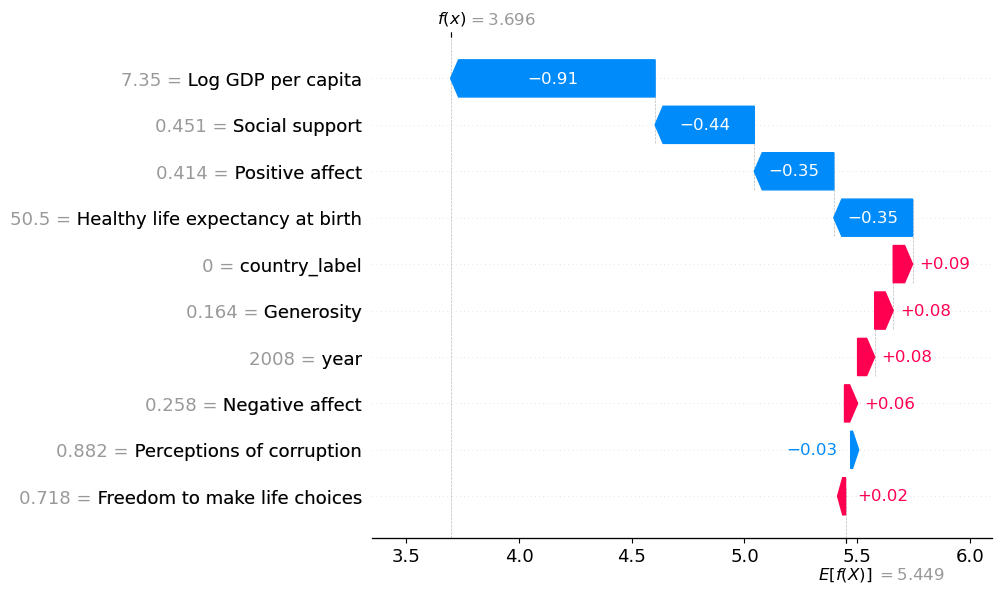

In [41]:
import lightgbm
from lightgbm import LGBMRegressor
import shap

model1 =lightgbm.LGBMRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model1)
shap_values = explainer(features_train)

shap.plots.waterfall(shap_values[0])


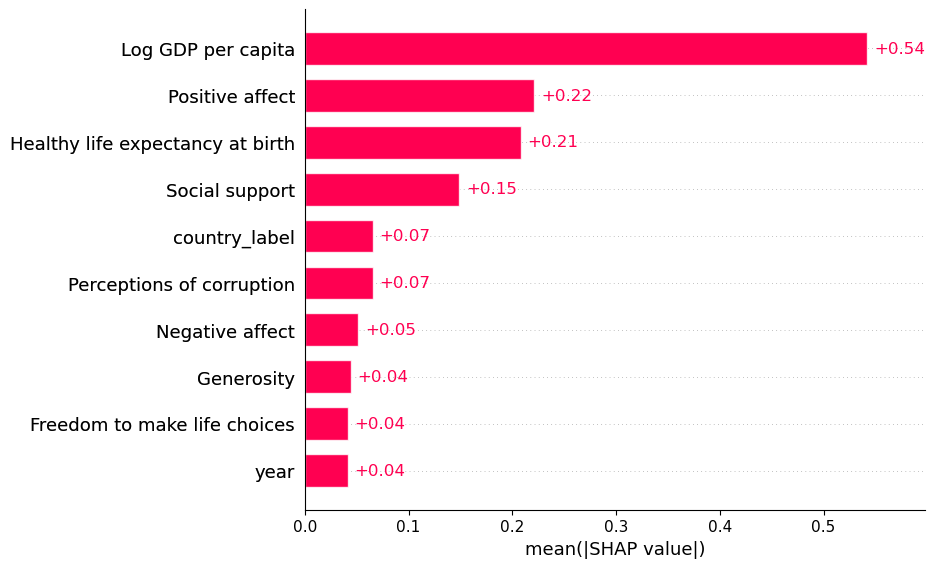

In [42]:
shap.plots.bar(shap_values)

Learning rate set to 0.044626
0:	learn: 1.0963346	total: 1.99ms	remaining: 1.98s
1:	learn: 1.0612144	total: 3.29ms	remaining: 1.64s
2:	learn: 1.0278523	total: 4.47ms	remaining: 1.49s
3:	learn: 0.9969295	total: 5.66ms	remaining: 1.41s
4:	learn: 0.9668442	total: 6.9ms	remaining: 1.37s
5:	learn: 0.9395862	total: 8.09ms	remaining: 1.34s
6:	learn: 0.9135088	total: 9.24ms	remaining: 1.31s
7:	learn: 0.8885151	total: 10.5ms	remaining: 1.3s
8:	learn: 0.8644008	total: 11.8ms	remaining: 1.3s
9:	learn: 0.8415540	total: 13.2ms	remaining: 1.31s
10:	learn: 0.8191188	total: 14.5ms	remaining: 1.31s
11:	learn: 0.7982412	total: 15.7ms	remaining: 1.29s
12:	learn: 0.7780339	total: 16.9ms	remaining: 1.28s
13:	learn: 0.7612855	total: 18.3ms	remaining: 1.28s
14:	learn: 0.7434443	total: 19.5ms	remaining: 1.28s
15:	learn: 0.7261445	total: 20.8ms	remaining: 1.28s
16:	learn: 0.7112221	total: 22.1ms	remaining: 1.27s
17:	learn: 0.6965188	total: 23.3ms	remaining: 1.27s
18:	learn: 0.6837074	total: 24.8ms	remaining: 1

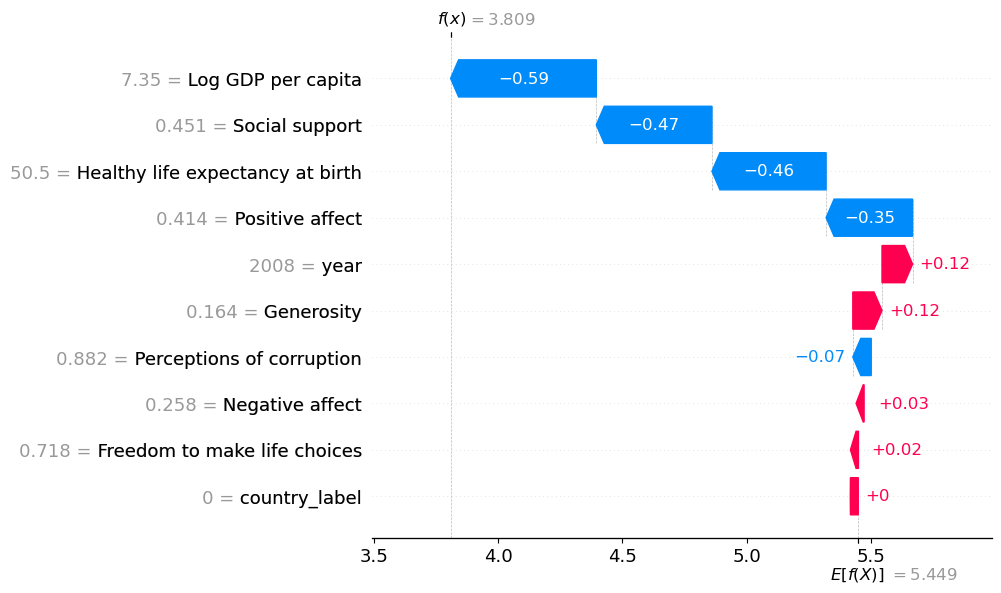

In [55]:

model3 =CatBoostRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model3)
shap_values = explainer(features_train)

shap.plots.waterfall(shap_values[0])